In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import pickle
import json
from tqdm import tqdm
import os, subprocess
import h5py
import random
import collections
import time

In [2]:
from importlib import reload

In [3]:
import pandas as pd
from scipy.stats import pearsonr

In [4]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [5]:
import rsatoolbox

In [6]:
np.random.seed(7)
torch.manual_seed(7)
random.seed(7)

In [7]:
from domainbed import hparams_registry
from domainbed import algorithms
from domainbed.lib import misc

In [8]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [9]:
import utils
import metrics

In [54]:
# choose between SceneCOCO, ColorObject
args = utils.load_param("ColorObject")
# args = utils.load_param("SceneCOCO")

In [42]:
#  read file
with open(f'saved_dict_causal_{args.dataset}.pkl', 'rb') as f:
    saved_dict = pickle.load(f)

# causal - fact

## setup

In [21]:
# read subspaces sets
num_rand_pairs = 100
h5_file = h5py.File(os.path.join(args.data_dir, f"test_subspaces_sample{num_rand_pairs}.h5py"), "r")
X_subspaces = h5_file.get('images')[()]
y_fg_classes_subspaces = h5_file.get('fg_classes')[()]
y_fg_indexes_subspaces = h5_file.get('fg_indexes')[()]
y_bg_classes_subspaces = h5_file.get('bg_classes')[()]
if args.dataset == "SceneCOCO":
    y_bg_indexes_subspaces = h5_file.get('bg_indexes')[()]
else:
    y_bg_indexes_subspaces = None

h5_file.close()

# dataloader - subspaces
dataset = utils.SimpleDataset_masksize(X_subspaces, np.zeros(X_subspaces.shape[0]), np.zeros(X_subspaces.shape[0]))
data_loader_subspaces = torch.utils.data.DataLoader(dataset=dataset, batch_size=256,
                                                 num_workers=0, shuffle=False)

In [22]:
# read ood1
h5_file = h5py.File(os.path.join(args.data_dir, "test_ood1.h5py"), "r")
X_OOD1 = h5_file.get('images')[()]
y_OOD1_fg = h5_file.get('fg_classes')[()]
y_OOD1_bg = h5_file.get('bg_classes')[()]
mask_size_OOD1 = np.zeros(X_OOD1.shape)
h5_file.close()

# probe set - ood1
dataset = utils.SimpleDataset_masksize(X_OOD1, y_OOD1_fg, mask_size_OOD1)
data_loader_OOD1 = torch.utils.data.DataLoader(dataset=dataset, batch_size=256,
                                                 num_workers=0, shuffle=False)

In [23]:
# read ood2
h5_file = h5py.File(os.path.join(args.data_dir, "test_ood20.1.h5py"), "r")
X_OOD2 = h5_file.get('images')[()]
y_OOD2_fg = h5_file.get('fg_classes')[()]
y_OOD2_bg = h5_file.get('bg_classes')[()]
mask_size_OOD2 = np.zeros(X_OOD2.shape)
h5_file.close()

# probe set - ood2
dataset = utils.SimpleDataset_masksize(X_OOD2, y_OOD2_fg, mask_size_OOD2)
data_loader_OOD2 = torch.utils.data.DataLoader(dataset=dataset, batch_size=256,
                                                 num_workers=0, shuffle=False)

In [24]:
imgs = X_subspaces.reshape((2, 10, 100, num_rand_pairs, 3, 64, 64))
X_subspaces.shape, imgs.shape

((200000, 3, 64, 64), (2, 10, 100, 100, 3, 64, 64))

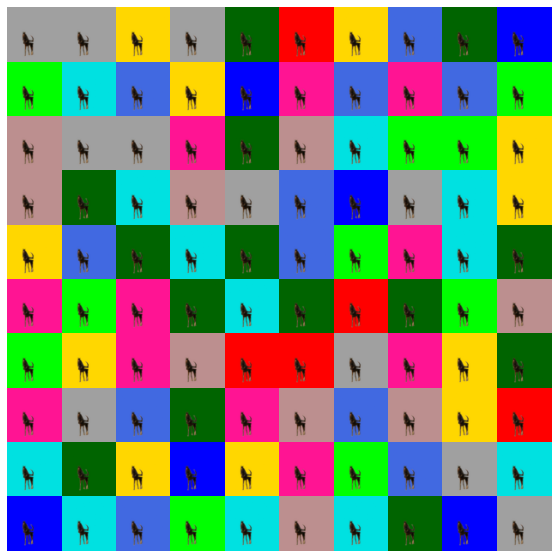

In [25]:
type_index = 0 # 0,1
class_index = 5 # 0-9
fg_index = 4 # 0-99
all_imges = []
for sample_index in range(100):
    all_imges.append(imgs[type_index, class_index, fg_index, sample_index].transpose([1,2,0]))
    
# set figure size and subplot size
fig, axs = plt.subplots(10, 10, figsize=(9.75, 10), gridspec_kw=dict(wspace=0, hspace=0))

# loop through the rows and columns of the grid
for i in range(10):
    for j in range(10):
        # plot the corresponding image in the grid
        axs[i,j].imshow(all_imges[i*10+j], cmap='gray')
        axs[i,j].axis('off')

## main exps

In [26]:
def get_pc_spaces(FEATS_subspaces, y_classes, y_indexes):
    labels = y_classes[:1000*num_rand_pairs]
    data = FEATS_subspaces['layer4'][:1000*num_rand_pairs]
    final_dim = 10
    # Compute class centers 
    unique_labels = np.unique(labels)
    class_centers = np.zeros((len(unique_labels), data.shape[1]))
    for i, label in enumerate(unique_labels):
        class_centers[i, :] = np.mean(data[labels == label], axis=0)
    # Compute inter-class PCs
    inter_class_pca = PCA()
    inter_class_pca.fit(class_centers)
    # Compute intra-class PCs
    intra_class_data = np.zeros_like(data)
    for i, label in enumerate(unique_labels):
        intra_class_data[labels == label] = data[labels == label] - class_centers[i]
    intra_class_pca = PCA()
    intra_class_pca.fit(intra_class_data)

    return inter_class_pca, intra_class_pca

def transform_data(ori_inputs, ori_outputs, transformation_matrix):
    # get class centers
    unique_labels = np.unique(ori_outputs)
    class_centers = np.zeros((len(unique_labels), ori_inputs.shape[1]))
    for i, label in enumerate(unique_labels):
        class_centers[i, :] = np.mean(ori_inputs[ori_outputs == label], axis=0)
    # get intra-class data
    intra_class_data = np.zeros_like(ori_inputs)
    for i, label in enumerate(unique_labels):
        intra_class_data[ori_outputs == label] = ori_inputs[ori_outputs == label] - class_centers[i]
    # transform
    transformed_class_centers = np.dot(class_centers, transformation_matrix.T)
    transformed_data = np.zeros_like(ori_inputs)
    for i, label in enumerate(unique_labels):
        transformed_data[ori_outputs == label] = intra_class_data[ori_outputs == label] + transformed_class_centers[i]
    
    return transformed_data

def decrease_fact(args, saved_dict, y_classes, y_indexes):
    print(args.exp_name)
    # get data and model
    _, model = utils.init_data_model(args, [])
    FEATS_subspaces = utils.get_feats(args, model, data_loader_subspaces, ["layer3"])
    FEATS_OOD1 = utils.get_feats(args, model, data_loader_OOD1, ["layer3"])
    FEATS_OOD2 = utils.get_feats(args, model, data_loader_OOD2, ["layer3"])
    
    ## get subspaces
    inter_class_pca, intra_class_pca = get_pc_spaces(FEATS_subspaces, y_classes, y_indexes)
    
    ## get transformation matrix
    final_dim = inter_class_pca.components_.shape[0]
    transformation_matrix = np.dot(inter_class_pca.components_.T, intra_class_pca.components_[:final_dim]).T # for Method 2 & 3
    
    ## transform the all the data
    transformed_data = np.dot(FEATS_subspaces['layer4'], transformation_matrix.T)
    
    ## compute factorization 
    # metrics_ori = metrics.compute_fact_subspaces(args, None, FEATS_subspaces, "10", False) # used in neurips main
    # metrics_trans = metrics.compute_fact_subspaces(args, None, {'layer4': transformed_data}, "10", False) # used in neurips main
    metrics_ori = metrics.compute_fact_subspaces(args, None, FEATS_subspaces, "1000", False)
    metrics_trans = metrics.compute_fact_subspaces(args, None, {'layer4': transformed_data}, "1000", False)
    
    # get OOD acc 
    acc_ori_ood1 = metrics.cv_test(FEATS_OOD1['layer4'], y_OOD1_fg, 5)
    acc_trans_ood1 = metrics.cv_test(transform_data(FEATS_OOD1['layer4'], y_OOD1_fg, transformation_matrix), 
                                    y_OOD1_fg, 5)
    acc_ori_ood2 = metrics.cv_test(FEATS_OOD2['layer4'], y_OOD2_fg, 5)
    acc_trans_ood2 = metrics.cv_test(transform_data(FEATS_OOD2['layer4'], y_OOD2_fg, transformation_matrix), 
                                    y_OOD2_fg, 5)
    
    acc_ori = (acc_ori_ood1[0]+acc_ori_ood2[0])/2, (acc_ori_ood1[1]+acc_ori_ood2[1])/2
    acc_trans = (acc_trans_ood1[0]+acc_trans_ood2[0])/2, (acc_trans_ood1[1]+acc_trans_ood2[1])/2
    
    return metrics_ori, acc_ori_ood1, acc_ori_ood2, metrics_trans, acc_trans_ood1, acc_trans_ood2

In [ ]:
## run causal fact exps
## 10 ERM - ColorObject & SceneObject
seed_list = [0, 7, 77, 8, 88, 
            1, 777, 7777, 888, 8888]

metrics_ori_list = []
acc_ood1_ori_list = []
acc_ood2_ori_list = []
metrics_trans_list = []
acc_ood1_trans_list = []
acc_ood2_trans_list = []

# ERM model
args.use_two_labels = False
args.use_mask = False
args.algorithm = _algo = "ERM"
    
for _seed in seed_list:
    args.trial_seed = _seed
    _exp_name=f"{args.bias}_ERM_seed{args.trial_seed}"
    args.exp_name = _exp_name

    results = decrease_fact(args, saved_dict, y_fg_classes_subspaces, y_fg_indexes_subspaces)
    metrics_ori, acc_ori_ood1, acc_ori_ood2, metrics_trans, acc_trans_ood1, acc_trans_ood2 = results
    
    saved_dict[args.exp_name] = {}
    saved_dict[args.exp_name]['metrics_ori'] = metrics_ori
    saved_dict[args.exp_name]['acc_ori_ood1'] = acc_ori_ood1
    saved_dict[args.exp_name]['acc_ori_ood2'] = acc_ori_ood2
    saved_dict[args.exp_name]['metrics_trans'] = metrics_trans
    saved_dict[args.exp_name]['acc_trans_ood1'] = acc_trans_ood1
    saved_dict[args.exp_name]['acc_trans_ood2'] = acc_trans_ood2

In [28]:
# save stuff
with open(f'saved_dict_causal_{args.dataset}.pkl', 'wb') as f:
    pickle.dump(saved_dict, f)

## plot

In [55]:
#  read stuff
with open(f'saved_dict_causal_{args.dataset}.pkl', 'rb') as f:
    saved_dict = pickle.load(f)

In [56]:
# read results
fact_before = np.zeros(10)
fact_after = np.zeros(10)
ood1_before = np.zeros(10)
ood1_after = np.zeros(10)
ood2_before = np.zeros(10)
ood2_after = np.zeros(10)


for seed_index, _seed in enumerate(seed_list):
    _exp_name=f"{args.bias}_ERM_seed{_seed}"
    
    fact_before[seed_index] = saved_dict[_exp_name]['metrics_ori'][0]
    ood1_before[seed_index] = saved_dict[_exp_name]['acc_ori_ood1'][0]
    ood2_before[seed_index] = saved_dict[_exp_name]['acc_ori_ood2'][0]
    
    fact_after[seed_index] = saved_dict[_exp_name]['metrics_trans'][0]
    ood1_after[seed_index] = saved_dict[_exp_name]['acc_trans_ood1'][0]
    ood2_after[seed_index] = saved_dict[_exp_name]['acc_trans_ood2'][0]

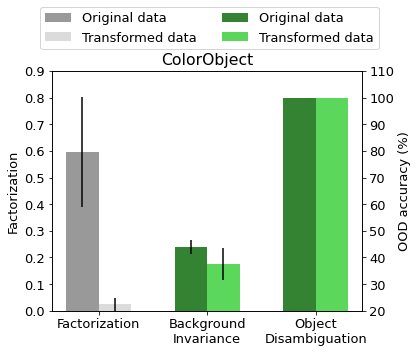

In [57]:
import matplotlib
matplotlib.rcParams.update({'font.size': 13})

dataset_name = args.dataset # ColorObject, SceneObject

metrics1_before = fact_before.mean()
metrics1_after = fact_after.mean()
metrics2_before = np.array([ood1_before.mean(), ood2_before.mean()]) * 100
metrics2_after = np.array([ood1_after.mean(), ood2_after.mean()]) * 100

errors1_before = fact_before.std()
errors1_after = fact_after.std()
errors2_before = np.array([ood1_before.std(), ood2_before.std()]) * 100
errors2_after = np.array([ood1_after.std(), ood2_after.std()]) * 100
    
bar_width = 0.3
opacity = 0.8


fig, ax1 = plt.subplots()

# Plotting the first metric
rects1 = ax1.bar(np.arange(1)-bar_width*0.5, metrics1_before, bar_width, alpha=opacity, color='grey', yerr=errors1_before, label='Original data')
rects2 = ax1.bar(np.arange(1)+bar_width*0.5, metrics1_after, bar_width, alpha=opacity, color='lightgrey', yerr=errors1_after, label='Transformed data')

ax1.set_ylabel('Factorization')
ax1.tick_params('y')
if dataset_name == 'SceneCOCO':
    ax1.set_ylim(0, 0.02)
elif dataset_name == 'ColorObject':
    ax1.set_ylim(0, 0.90)

# Adding a second y axis for the second metric
# burlywood, antiquewhite
ax2 = ax1.twinx()
rects3 = ax2.bar(np.arange(2)+1 - bar_width*0.5, metrics2_before, bar_width, alpha=opacity, color='darkgreen', yerr=errors2_before, label='Original data')
rects4 = ax2.bar(np.arange(2)+1 + bar_width*0.5, metrics2_after, bar_width, alpha=opacity, color='limegreen', yerr=errors2_after, label='Transformed data')

ax2.set_ylabel('OOD accuracy (%)')
ax2.tick_params('y')
if dataset_name == 'SceneCOCO':
    ax2.set_ylim(20,100)
elif dataset_name == 'ColorObject':
    ax2.set_ylim(20,110)


# Adding legends
fig.tight_layout()
fig.legend(loc='center', bbox_to_anchor=(0.5, 1.1), ncol=2)

# Adding xticks 
plt.xticks(np.arange(3), ('Factorization', 'Background\nInvariance', 'Object\nDisambiguation'))
plt.title(f'{dataset_name}')
plt.savefig(f"./fig/causal_fact_new_{dataset_name}.pdf", format="pdf", dpi=500, bbox_inches = "tight")
plt.show()

# casual - wt evid

## main exp

In [62]:
# read subspaces sets
num_rand_pairs = 100
h5_file = h5py.File(os.path.join(args.data_dir, f"test_subspaces_sample{num_rand_pairs}.h5py"), "r")
X_subspaces = h5_file.get('images')[()]
y_fg_classes_subspaces = h5_file.get('fg_classes')[()]
y_bg_classes_subspaces = h5_file.get('bg_classes')[()]

h5_file.close()
# dataloader - subspaces
dataset = utils.SimpleDataset_masksize(X_subspaces, np.zeros(X_subspaces.shape[0]), np.zeros(X_subspaces.shape[0]))
data_loader_subspaces = torch.utils.data.DataLoader(dataset=dataset, batch_size=256,
                                                 num_workers=0, shuffle=False)

In [63]:
# read ood1
h5_file = h5py.File(os.path.join(args.data_dir, "test_ood1.h5py"), "r")
X_OOD1 = h5_file.get('images')[()]
y_OOD1_fg = h5_file.get('fg_classes')[()]
y_OOD1_bg = h5_file.get('bg_classes')[()]
mask_size_OOD1 = np.zeros(X_OOD1.shape)
h5_file.close()

dataset = utils.SimpleDataset_masksize(X_OOD1, y_OOD1_fg, mask_size_OOD1)
data_loader_OOD1 = torch.utils.data.DataLoader(dataset=dataset, batch_size=256,
                                                 num_workers=0, shuffle=False)

# read ood2
h5_file = h5py.File(os.path.join(args.data_dir, "test_ood20.1.h5py"), "r")
X_OOD2 = h5_file.get('images')[()]
y_OOD2_fg = h5_file.get('fg_classes')[()]
y_OOD2_bg = h5_file.get('bg_classes')[()]
mask_size_OOD2 = np.zeros(X_OOD2.shape)
h5_file.close()

dataset = utils.SimpleDataset_masksize(X_OOD2, y_OOD2_fg, mask_size_OOD2)
data_loader_OOD2 = torch.utils.data.DataLoader(dataset=dataset, batch_size=256,
                                                 num_workers=0, shuffle=False)

In [64]:
def get_pca(FEATS_subspaces):
    # get PC subspaces
    feats = FEATS_subspaces['layer4']
    shape = (1000, num_rand_pairs, 128)
    fg_feats = feats[:1000*num_rand_pairs].reshape(shape)
    bg_feats = feats[1000*num_rand_pairs:].reshape(shape)
    fg_centers = fg_feats.mean(1)
    bg_centers = bg_feats.mean(1)

    # compute PCA space
    pca_fg = PCA() 
    pca_fg.fit(fg_centers)
    pca_bg = PCA() 
    pca_bg.fit(bg_centers)
    return pca_fg, pca_bg
    
def boost_subspace(feats, pca, boost_factor):
    ### compute importance + boost original space
    # contribution = np.abs(pca.components_[0])
    eigenvectors = pca.components_
    eigenvalues = pca.explained_variance_
    
    contribution = (np.abs(eigenvectors).T * np.sqrt(eigenvalues)).T.sum(0)
    
    # Normalize the contributions so they sum up to 128
    contribution = contribution / np.sum(contribution) * 128
    # Scale the original data according to the contribution of each feature in pca
    boosted_feats = feats * contribution * boost_factor
    
    return boosted_feats

In [65]:
idx = np.random.randint(100000, size=7500)
n_splits = 3

In [ ]:
## get feats subspaces
is_normalize = True
seed_list = [0, 7, 77, 8, 88, 
            1, 777, 7777, 888, 8888]

# ERM model
args.use_two_labels = False
args.use_mask = False
args.algorithm = _algo = "ERM"

for _seed in seed_list:
   
    args.trial_seed = _seed
    _exp_name=f"{args.bias}_ERM_seed{args.trial_seed}"
    args.exp_name = _exp_name
    print(_exp_name)
    
    if args.exp_name not in saved_dict:
        saved_dict[args.exp_name] = {}
    
    start_time = time.time()
    # get data/model
    eval_names = []
    _, model = utils.init_data_model(args, eval_names)
    FEATS_subspaces = utils.get_feats(args, model, data_loader_subspaces, ["layer3"])
    FEATS_OOD1 = utils.get_feats(args, model, data_loader_OOD1, ["layer3"])
    FEATS_OOD2 = utils.get_feats(args, model, data_loader_OOD2, ["layer3"])
    
    if is_normalize: 
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        FEATS_subspaces['layer4'] = scaler.fit_transform(FEATS_subspaces['layer4'])
        FEATS_OOD1['layer4'] = scaler.fit_transform(FEATS_OOD1['layer4'])
        FEATS_OOD2['layer4'] = scaler.fit_transform(FEATS_OOD2['layer4'])
    
    # get PCA
    pca_fg, pca_bg = get_pca(FEATS_subspaces)

    # # baselines
    print("\nori acc...")
    _acc_ood1 = metrics.cv_test(FEATS_subspaces['layer4'][idx], y_fg_classes_subspaces[idx], n_splits)
    _acc_ood2 = metrics.cv_test(FEATS_OOD2['layer4'], y_OOD2_fg, n_splits)
    # record
    saved_dict[args.exp_name]['ood1_ori'] = _acc_ood1[0]
    saved_dict[args.exp_name]['ood2_ori'] = _acc_ood2[0]
    
    for boost_factor in [1/64, 1/16, 1/4,
                         4, 16, 64]:
        print("==>boost factor", boost_factor)
        
        # change original space 
        print('====>change original space...')
        boosted_feats_subspaces = FEATS_subspaces['layer4'] * boost_factor
        _acc_ood1 = metrics.cv_test(boosted_feats_subspaces[idx], y_fg_classes_subspaces[idx], n_splits, 1)
        boosted_feats_OOD2 = FEATS_OOD2['layer4'] * boost_factor
        _acc_ood2 = metrics.cv_test(boosted_feats_OOD2, y_OOD2_fg, n_splits, 1)
        saved_dict[args.exp_name][f'norm_method3_ood1_direct_{boost_factor}'] = _acc_ood1[0]
        saved_dict[args.exp_name][f'norm_method3_ood2_direct_{boost_factor}'] = _acc_ood2[0]
        
        # change fg
        print('====>change fg subspace...')
        boosted_feats_subspaces = boost_subspace(FEATS_subspaces['layer4'], pca_fg, boost_factor)
        _acc_ood1 = metrics.cv_test(boosted_feats_subspaces[idx], y_fg_classes_subspaces[idx], n_splits, 1)
        boosted_feats_OOD2 = boost_subspace(FEATS_OOD2['layer4'], pca_fg, boost_factor)
        _acc_ood2 = metrics.cv_test(boosted_feats_OOD2, y_OOD2_fg, n_splits, 1)
        saved_dict[args.exp_name][f'norm_method3_ood1_fg_{boost_factor}'] = _acc_ood1[0]
        saved_dict[args.exp_name][f'norm_method3_ood2_fg_{boost_factor}'] = _acc_ood2[0]

        # change bg
        print('====>change bg subspace...')
        boosted_feats_subspaces = boost_subspace(FEATS_subspaces['layer4'], pca_bg, boost_factor)
        _acc_ood1 = metrics.cv_test(boosted_feats_subspaces[idx], y_fg_classes_subspaces[idx], n_splits, 1)
        boosted_feats_OOD2 = boost_subspace(FEATS_OOD2['layer4'], pca_bg, boost_factor)
        _acc_ood2 = metrics.cv_test(boosted_feats_OOD2, y_OOD2_fg, n_splits, 1)
        saved_dict[args.exp_name][f'norm_method3_ood1_bg_{boost_factor}'] = _acc_ood1[0]
        saved_dict[args.exp_name][f'norm_method3_ood2_bg_{boost_factor}'] = _acc_ood2[0]


    print("time past: %.4f\n" % (time.time()-start_time))

In [68]:
# save stuff
with open(f'saved_dict_causal_{args.dataset}.pkl', 'wb') as f:
    pickle.dump(saved_dict, f)

## plot

In [59]:
#  read stuff
with open(f'saved_dict_causal_{args.dataset}.pkl', 'rb') as f:
    saved_dict = pickle.load(f)

In [ ]:
seed_list = [0, 7, 77, 8, 88, 
            1, 777, 7777, 888, 8888]    
    
    
results_direct_ood1 = np.zeros((7, 10))
results_direct_ood2 = np.zeros((7, 10))
results_fg_ood1 = np.zeros((7, 10))
results_fg_ood2 = np.zeros((7, 10))
results_bg_ood1 = np.zeros((7, 10))
results_bg_ood2 = np.zeros((7, 10))

prefix = 'norm_method3_'

for seed_index, _seed in enumerate(seed_list):
    _algo = "ERM"
    _exp_name=f"{args.bias}_{_algo}_seed{_seed}"
    
    for boost_index, boost_factor in enumerate([1/64, 1/16, 1/4, 4, 16, 64]):
        if boost_index>=3:
            boost_index += 1
        
        results_direct_ood1[boost_index][seed_index] = saved_dict[_exp_name][f'{prefix}ood1_direct_{boost_factor}']
        results_direct_ood2[boost_index][seed_index] = saved_dict[_exp_name][f'{prefix}ood2_direct_{boost_factor}']
        
        results_fg_ood1[boost_index][seed_index] = saved_dict[_exp_name][f'{prefix}ood1_fg_{boost_factor}']
        results_fg_ood2[boost_index][seed_index] = saved_dict[_exp_name][f'{prefix}ood2_fg_{boost_factor}']
                                                    
        results_bg_ood1[boost_index][seed_index] = saved_dict[_exp_name][f'{prefix}ood1_bg_{boost_factor}']
        results_bg_ood2[boost_index][seed_index] = saved_dict[_exp_name][f'{prefix}ood2_bg_{boost_factor}']

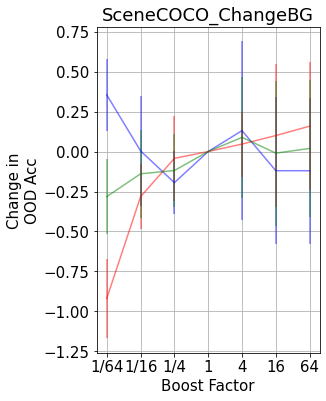

In [27]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(4,6))

xx = ["1/64", "1/16", "1/4", "1", "4", "16", "64"]

dataset_name = f"{args.dataset}_ChangeBG" # _ChangeFG, _ChangeBG, _ChangeFullSpace
if dataset_name == f"{args.dataset}_ChangeBG":
    ood1_mean_list, ood1_std_list = (results_fg_ood1-results_direct_ood1).mean(1)*100, (results_fg_ood1-results_direct_ood1).std(1)*100
    ood2_mean_list, ood2_std_list = (results_fg_ood2-results_direct_ood2).mean(1)*100, (results_fg_ood2-results_direct_ood2).std(1)*100
elif dataset_name == f"{args.dataset}_ChangeFG":
    ood1_mean_list, ood1_std_list = (results_bg_ood1-results_direct_ood1).mean(1)*100, (results_bg_ood1-results_direct_ood1).std(1)*100
    ood2_mean_list, ood2_std_list = (results_bg_ood2-results_direct_ood2).mean(1)*100, (results_bg_ood2-results_direct_ood2).std(1)*100
    
plt.errorbar(xx, ood1_mean_list, yerr=ood1_std_list, color='blue', label=f'OOD1', alpha=0.5)
plt.errorbar(xx, ood2_mean_list, yerr=ood2_std_list, color='red', label=f'OOD2', alpha=0.5)
plt.errorbar(xx, (ood1_mean_list+ood2_mean_list)/2, 
             yerr=(ood1_std_list+ood2_std_list)/2,
             color='green', label=f'AvgOOD', alpha=0.5)
# plt.legend(bbox_to_anchor=[1,1.2], ncol=3)
plt.xlabel("Boost Factor")
plt.ylabel("Change in\nOOD Acc")
plt.title(f"{dataset_name}")
plt.grid(True)
plt.savefig(f"./fig/causal_wt_evid_boost_factor_{dataset_name}.pdf", format="pdf", dpi=500, bbox_inches = "tight")

# Displaying the plot
plt.show()

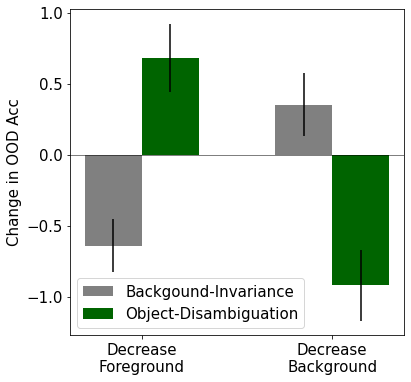

In [53]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})


diff_ood1_mean_list = np.array([(results_bg_ood1-results_direct_ood1).mean(1)[0], 
                                (results_fg_ood1-results_direct_ood1).mean(1)[0]]) * 100
diff_ood2_mean_list = np.array([(results_bg_ood2-results_direct_ood2).mean(1)[0], 
                                (results_fg_ood2-results_direct_ood2).mean(1)[0]]) * 100
diff_ood1_std_list = np.array([(results_bg_ood1-results_direct_ood1).std(1)[0], 
                                (results_fg_ood1-results_direct_ood1).std(1)[0]]) * 100
diff_ood2_std_list = np.array([(results_bg_ood2-results_direct_ood2).std(1)[0], 
                                (results_fg_ood2-results_direct_ood2).std(1)[0]]) * 100
# Plotting the bar plots
width = 0.3  # Width of the bars
x = range(2)  # X-axis range

fig, ax = plt.subplots(figsize=(6, 6))
rects1 = ax.bar(x, diff_ood1_mean_list, yerr=diff_ood1_std_list,
                color='grey', width=width, label='Backgound-Invariance')
rects2 = ax.bar([i + width for i in x], diff_ood2_mean_list, yerr=diff_ood2_std_list,
                color='darkgreen', width=width, label='Object-Disambiguation')

# Adding labels, title, and legend
ax.set_ylabel('Change in OOD Acc')
# ax.set_title('Significant Effects of Causal Manipulation')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(['Decrease\nForeground', 'Decrease\nBackground'])
ax.legend(loc='best')
ax.axhline(0, color='black', linewidth=0.5)

plt.savefig(f"./fig/causal_wt_evid_new_{args.dataset}_{_algo}.pdf", format="pdf", dpi=500, bbox_inches = "tight")

# Displaying the plot
plt.show()